<a href="https://colab.research.google.com/github/rrfsantos/Desafios-NLP/blob/main/Desafio-NLP--Classificacao/Tweets_Covid_19_AnaliseSentimentos_GloVe_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de sentimentos (classificação) de tweets relacionados a COVID-19, utilizando Embedding e CNN-LSTM

### Dataset: Coronavirus tweets NLP - Text Classification - https://www.kaggle.com/datatattle/covid-19-nlp-text-classification




In [46]:
!pip install contractions

In [47]:
# Importar bibliotecas
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style('white')
sns.set_palette('dark')
sns.set_context('talk')
%matplotlib inline
from PIL import Image

import nltk
import spacy
import re
import string
import unicodedata
import warnings

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#from nltk import bigrams
#from nltk import trigrams
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from keras.optimizers import Adam, SGD
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

from contractions import contractions_dict
from wordcloud import WordCloud
from bs4 import BeautifulSoup

warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
!python -m spacy download en_core_web_md
!python -m spacy link en_core_web_md en --force

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_md -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [49]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/desafio 1/'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
# Carregar as bases de treino e teste
df_train = pd.read_csv('Corona_NLP_train.csv', engine='python')
df_test = pd.read_csv('Corona_NLP_test.csv', engine='python')

In [51]:
df_train.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis = 1, inplace=True)
df_test.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis = 1, inplace=True)

In [52]:
df_train.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [53]:
df_test.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [54]:
### Verificar valores nulos
print('df_train.OriginalTweet: ', (df_train.OriginalTweet.isna()).sum())
print('df_train.Sentiment: ',(df_train.Sentiment.isna()).sum())
print('df_test.OriginalTweet: ', (df_test.OriginalTweet.isna()).sum())
print('df_test.Sentiment: ',(df_test.Sentiment.isna()).sum())

df_train.OriginalTweet:  0
df_train.Sentiment:  0
df_test.OriginalTweet:  0
df_test.Sentiment:  0


## Análises estatísticas

### Número de tweets na base de treino e de teste

In [55]:
print('Número de Tweets na base de treino: ', len(df_train))
print('Número de Tweets na base de test: ', len(df_test))

Número de Tweets na base de treino:  41157
Número de Tweets na base de test:  3798


### Distribuição de tweets por Classe

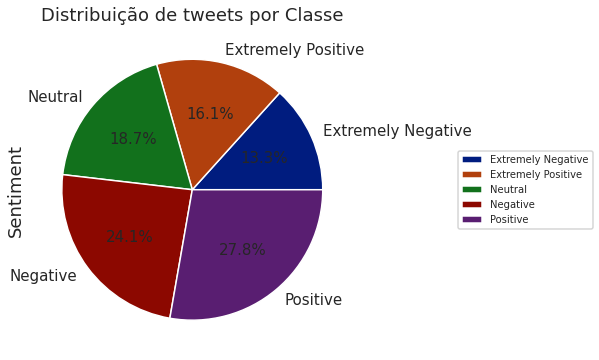

In [56]:
df_distribution = df_train.Sentiment.value_counts()\
                            .to_frame()\
                            .sort_values('Sentiment')

df_distribution.plot.pie(y='Sentiment', autopct='%1.1f%%',\
                            title='Distribuição de tweets por Classe',\
                            figsize=(6, 6), textprops = {"fontsize": 15}, labeldistance = 1.1)\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5),fontsize='medium')

plt.show;   

In [57]:
df_distribution.sort_values('Sentiment', ascending=False)

,Sentiment
Positive,11422
Negative,9917
Neutral,7713
Extremely Positive,6624
Extremely Negative,5481


### Tamanho dos tweets por classe

In [58]:
df_train['text_length'] = df_train.OriginalTweet.apply(len)
df_train.head()

,OriginalTweet,Sentiment,text_length
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,111
1,advice Talk to your neighbours family to excha...,Positive,237
2,Coronavirus Australia: Woolworths to give elde...,Positive,131
3,My food stock is not the only one which is emp...,Positive,306
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,310


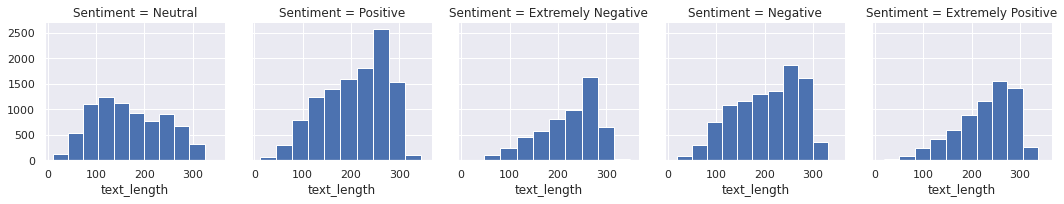

In [59]:
sns.set(font_scale = 1)
g = sns.FacetGrid(df_train,col='Sentiment')
g.map(plt.hist,'text_length')
plt.show();

### Tamanho médio dos tweets por classe

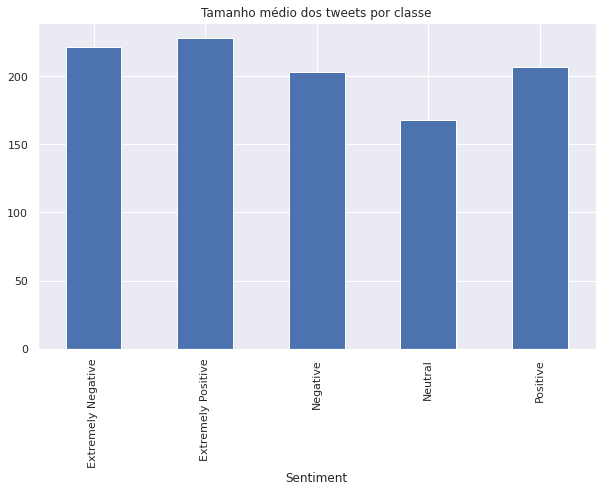

In [60]:
df_group = df_train.groupby(['Sentiment'])['text_length'].agg('mean')
df_group.plot.bar(title='Tamanho médio dos tweets por classe', figsize=(10, 6))
plt.show();

In [61]:
encoding = {'Extremely Negative': 'Negative',
            'Negative': 'Negative',
            'Neutral': 'Neutral',
            'Positive': 'Positive',
            'Extremely Positive': 'Positive'
           }

labels = ['Negative', 'Neutral', 'Positive']
           
df_train["Sentiment"].replace(encoding, inplace=True)
df_test["Sentiment"].replace(encoding, inplace=True)

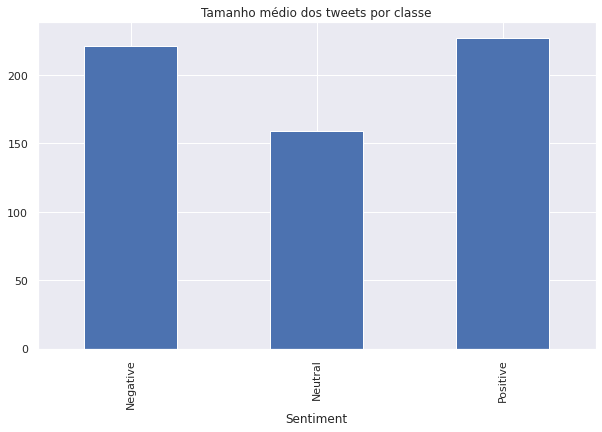

In [62]:
df_group = df_train.groupby(['Sentiment'])['text_length'].agg('median')
df_group.plot.bar(title='Tamanho médio dos tweets por classe', figsize=(10, 6))
plt.show();

### Distribuição da quantidade de palavras nos tweets

In [63]:
df_train['word_count'] = df_train.OriginalTweet.apply(lambda x: len(str(x).split()))
df_train.head()

,OriginalTweet,Sentiment,text_length,word_count
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,111,8
1,advice Talk to your neighbours family to excha...,Positive,237,38
2,Coronavirus Australia: Woolworths to give elde...,Positive,131,14
3,My food stock is not the only one which is emp...,Positive,306,42
4,"Me, ready to go at supermarket during the #COV...",Negative,310,40


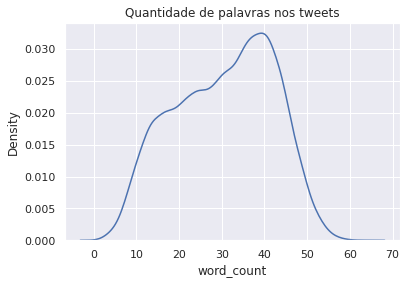

In [64]:
sns.distplot(df_train.word_count, hist=False)
plt.title('Quantidade de palavras nos tweets')
plt.show();

## Pré-processamento do texto


In [65]:
### Remove caracteres especiais e transforma em minúsculos
def remove_special_characters(text, remove_digits=False):
  special_char_pattern = re.compile(r'([{.(-)!}])')
  text = special_char_pattern.sub(" \\1 ", text)

  pattern = r'[^a-zA-z0-9\s]'
  text = re.sub(pattern, '', text)
  return text

df_train['OriginalTweet'] = df_train.OriginalTweet.map(remove_special_characters).str.lower()
df_test['OriginalTweet'] = df_test.OriginalTweet.map(remove_special_characters).str.lower()

In [66]:
### Remove acentos
def remove_accent(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text
df_train['OriginalTweet'] = df_train.OriginalTweet.map(remove_accent)
df_test['OriginalTweet'] = df_test.OriginalTweet.map(remove_accent)

In [67]:
### Remove links
def strip_html_tags(text):
  text = re.sub(r"http[s]?://\S+", "", text)
  text = re.sub(r"\s+", " ", text)
  soup = BeautifulSoup(text, "html.parser")
  stripped_text = soup.get_text()
  return stripped_text

df_train['OriginalTweet'] = df_train.OriginalTweet.map(strip_html_tags)
df_test['OriginalTweet'] = df_test.OriginalTweet.map(strip_html_tags)

In [68]:
### Expande contrações
def expand_contractions(text, contraction_mapping=contractions_dict):
  contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                    flags=re.IGNORECASE | re.DOTALL)

  def expand_match(contraction):
      match = contraction.group(0)
      first_char = match[0]
      expanded_contraction = contraction_mapping.get(match) \
          if contraction_mapping.get(match) \
          else contraction_mapping.get(match.lower())
      expanded_contraction = first_char + expanded_contraction[1:]
      return expanded_contraction
  
  try:
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
  except:
    return text
  return expanded_text

df_train['OriginalTweet'] = df_train.OriginalTweet.map(expand_contractions)
df_test['OriginalTweet'] = df_test.OriginalTweet.map(expand_contractions)

In [69]:
### Lemetização
nlp = spacy.load('en')

def lemmatize(text):
  text = nlp(text)
  text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
  return text

df_train['OriginalTweet'] = df_train.OriginalTweet.map(lemmatize)
df_test['OriginalTweet'] = df_test.OriginalTweet.map(lemmatize)

In [70]:
### Remove stopwords
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
stopword_list.append('pic.twitter.com')
stopword_list.append('pic')
stopword_list.append('twitter')
stopword_list.append('http')
stopword_list.append('httpst')
stopword_list.append('amp')
#stopword_list.append('covid')
#stopword_list.append('covid19')
#stopword_list.append('covid_19')
#stopword_list.append('covid2019')
#stopword_list.append('coronavirus')
#stopword_list.append('covid')
#stopword_list.append('19')
stopword_list.append('100')
stopword_list.append('10')

df_train['OriginalTweet'] = df_train.OriginalTweet.map(word_tokenize)
df_test['OriginalTweet'] = df_test.OriginalTweet.map(word_tokenize)

def remove_stopwords(text):
  tokens = text
  tokens = [token.strip() for token in tokens]
  filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
  filtered_text = ' '.join(filtered_tokens)
  return filtered_text

df_train['OriginalTweet'] = df_train.OriginalTweet.map(remove_stopwords)
df_test['OriginalTweet'] = df_test.OriginalTweet.map(remove_stopwords)

df_train.head()  

,OriginalTweet,Sentiment,text_length,word_count
0,menyrbie phil_gahan chrisitv coifz9fan2pa coxx...,Neutral,111,8
1,advice talk neighbour family exchange phone nu...,Positive,237,38
2,coronavirus australia woolworths give elderly ...,Positive,131,14
3,food stock not one ehempty please not panic en...,Positive,306,42
4,ready go supermarket covid19 outbreak not para...,Negative,310,40


## WordCloud

In [71]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df_train.OriginalTweet)
corpus[:5]

['menyrbie', 'phil_gahan', 'chrisitv', 'coifz9fan2pa', 'coxx6ghgfzcc']

In [72]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Unigrams

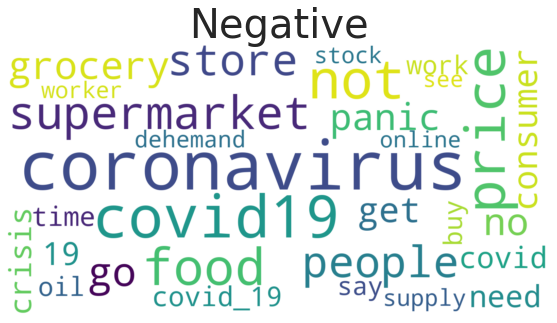

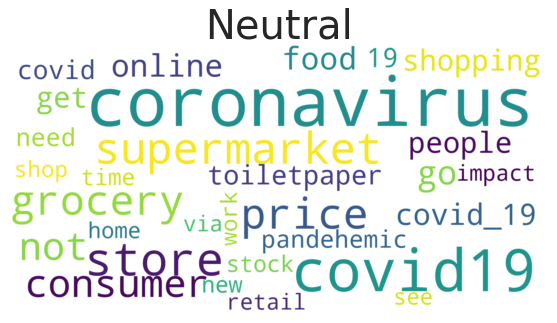

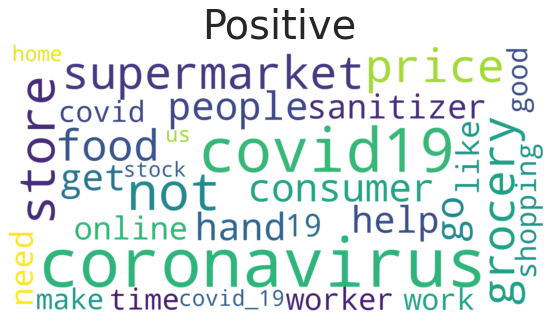

In [73]:
### Converte lista strings em um único texto
labels = np.unique(df_train.Sentiment)
for label in labels:
    rows = df_train[df_train.Sentiment == label]
    corpus = get_corpus(rows.OriginalTweet)
    counter = Counter(corpus)
    most_common = counter.most_common(30)
    most_common = dict(most_common)
  
    ## Plotagem da WordCloud       
    cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200,max_words=50).generate_from_frequencies(most_common)

    plt.figure(figsize = (10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(label, fontsize=40)
    plt.axis('off')
    plt.show;  

### Bigrams

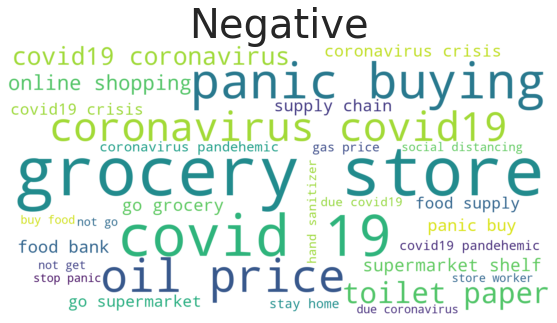

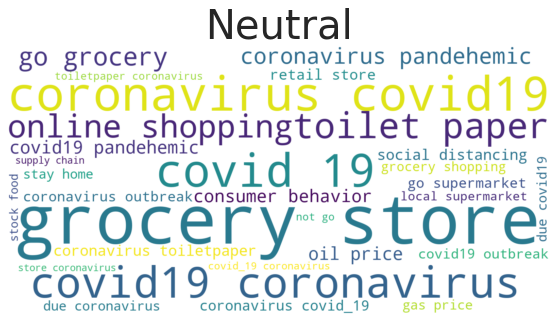

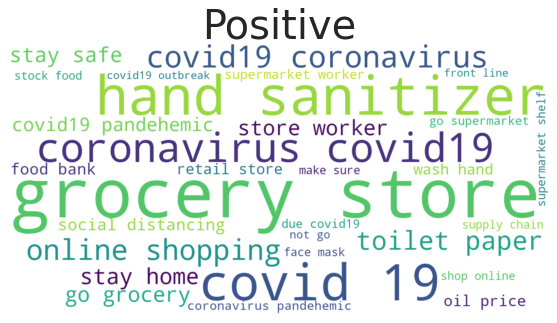

In [74]:
### Converte lista de strings em um único texto
labels = np.unique(df_train.Sentiment)
for label in labels:
    rows = df_train[df_train.Sentiment == label]
    most_common = get_top_text_ngrams(rows.OriginalTweet,30,2)
    most_common = dict(most_common)
      
    ## Plotagem da WordCloud       
    cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200,max_words=50).generate_from_frequencies(most_common)

    plt.figure(figsize = (10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(label, fontsize=40)
    plt.axis('off')
    plt.show;

### Trigrams

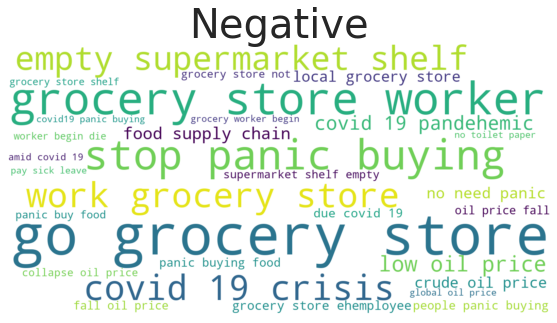

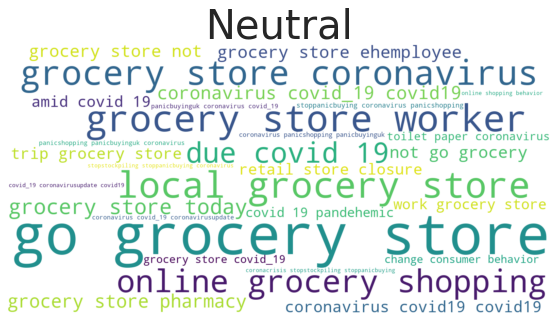

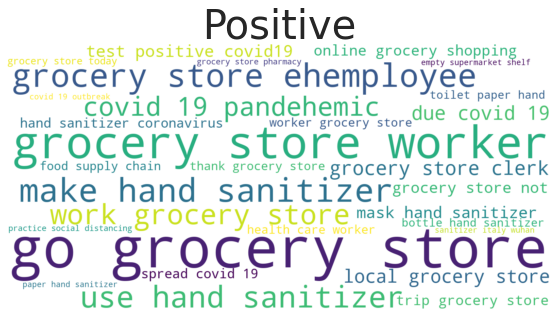

In [75]:
### Converte lista strings em um único texto
labels = np.unique(df_train.Sentiment)
for label in labels:
    rows = df_train[df_train.Sentiment == label]
    most_common = get_top_text_ngrams(rows.OriginalTweet,30,3)
    most_common = dict(most_common)
      
    ## Plotagem da WordCloud       
    cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200,max_words=50).generate_from_frequencies(most_common)

    plt.figure(figsize = (10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(label, fontsize=40)
    plt.axis('off')
    plt.show;

## Análise de Sentimentos - Classificação dos Tweets

### GloVe + CNN-LSTM

In [359]:
seed = 101 # fix random seed
np.random.seed(seed)

In [360]:
batch_size = 32
epochs = 10
max_features = 30000 # número máximo de palavras utilizado para o vocabulário (número de "vetores de palavras")
init_lr = 1e-3

In [361]:
# Encode variável categórica
X_train = df_train['OriginalTweet']
y_train = pd.get_dummies(df_train['Sentiment']).values

X_test = df_test['OriginalTweet']
y_test = pd.get_dummies(df_test['Sentiment']).values

num_classes = df_train['Sentiment'].nunique()

In [362]:
max_features = max_features
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

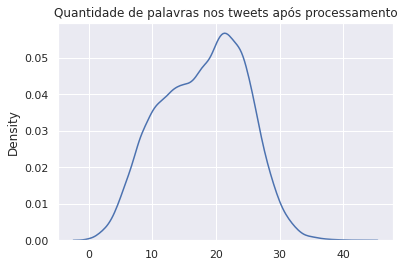

In [363]:
totalNumWords = [len(one_comment) for one_comment in X_train]
sns.distplot(totalNumWords, hist=False)
plt.title('Quantidade de palavras nos tweets após processamento')
plt.show();

In [364]:
max_words = 50 # número máximo de palavras em um comentário
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(41157, 50) (3798, 50)


In [365]:
# Callbacks
es = EarlyStopping(patience=5,monitor="val_loss", mode='auto', restore_best_weights=True)
#rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
mc = ModelCheckpoint(filepath='bestV.h5', save_best_only=True)
rlr = ReduceLROnPlateau(monitor='val_acc', patience = 4, verbose=1,factor=0.5, min_lr=0.00001)

In [366]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_embed_mat(EMBEDDING_FILE, max_features=max_features):
    # word vectors
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf8'))
    print('Found %s word vectors.' % len(embeddings_index))

    # embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) + 1)
    all_embs = np.stack(embeddings_index.values()) #for random init
    embedding_matrix = np.random.normal(all_embs.mean(), all_embs.std(), 
                                        (num_words, embed_dim))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    max_features = embedding_matrix.shape[0]
    
    return max_features, embedding_matrix

In [367]:
def get_model(max_features, embed_dim, embedding_matrix):
    np.random.seed(seed)
    K.clear_session()
    opt = Adam(lr=init_lr)
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],
                       weights=[embedding_matrix]))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(embed_dim, dropout=0.5, recurrent_dropout=0.5))
    #model.add(Dense(32, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
    print(model.summary())
    return model

In [368]:
def model_train(model):
    # train the model
    model_history = model.fit(X_train, y_train, validation_split=0.1, 
                          epochs=epochs, batch_size=batch_size, verbose=2,callbacks=[es,rlr,mc])
    # plot train history
    plot_model_history(model_history)

In [369]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show();

In [370]:
def model_evaluate(): 
    # predict class with test set
    y_pred_test =  model.predict_classes(X_test, batch_size=batch_size, verbose=0)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
    
    #classification report
    print('\n')
    print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test)

    fig, ax = plt.subplots(figsize=(8,8))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
   
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show();

Found 400000 word vectors.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 32)            9632      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                

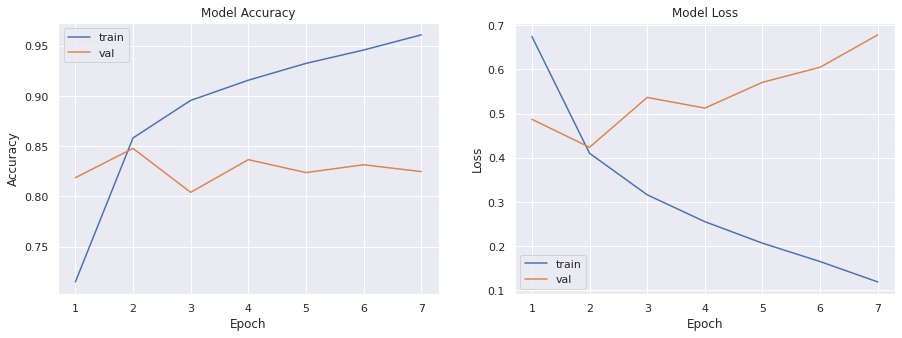

In [371]:
# embedding matrix
EMBEDDING_FILE = 'glove.6B.100d.txt' ### Teste anterior com glove.6B.100d.txt
embed_dim = 100 # --> Cada palavra é representada por um vetor de 100 dimensões (glove.6B.100d.txt)
max_features, embedding_matrix = get_embed_mat(EMBEDDING_FILE)

# train the model
model = get_model(max_features, embed_dim, embedding_matrix)
model_train(model)

Accuracy:	84.2%


              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1633
           1       0.83      0.75      0.79       619
           2       0.86      0.83      0.85      1546

    accuracy                           0.84      3798
   macro avg       0.84      0.82      0.83      3798
weighted avg       0.84      0.84      0.84      3798



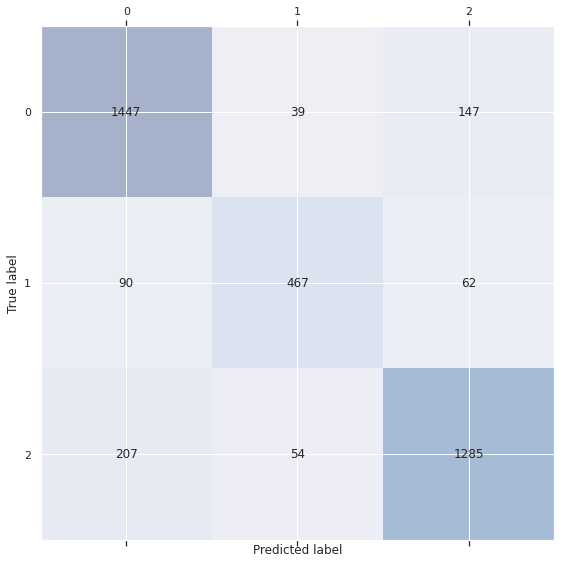

In [372]:
model_evaluate()